In [1]:
import torch
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
%matplotlib inline

In [2]:
import pycuda.driver as cuda
cuda.init()
torch.cuda.current_device()

0

In [3]:
def find_gender(filename):
    demographics = filename.split("_")
    gender = min(int(demographics[1]), 1)
    return gender

In [4]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = find_gender(self.imgs[index][0])
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [5]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = ImageFolderWithPaths(root="data/", transform=ToTensor())

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create the dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)

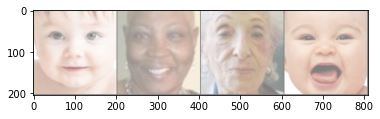

tensor(0)
tensor(1)
tensor(1)
tensor(1)


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(testloader)
images, idk, filename = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))

for fname in filename:
    print(fname)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        if torch.cuda.is_available(): self.cuda()
        self.conv1 = nn.Conv2d(3, 6, 4)
        self.pool = nn.MaxPool2d(8, 8)
        self.conv2 = nn.Conv2d(6, 16, 4)
        self.fc1 = nn.Linear(16 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,2)  #age (0 to 1 * 100), gender (<0.5 -> F, >=0.5 -> M), race ((0 to 1) / nraces) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.to(torch.device("cuda:0"))

Net(
  (conv1): Conv2d(3, 6, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=64, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [8]:
#loss_function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
#Training the network
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, _, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()        

        # forward + backward + optimize
        outputs = net(inputs.cuda())
                
        outputs = torch.reshape(outputs, (4,2))
                
        loss = criterion(outputs, labels.cuda())
        loss.backward()
        optimizer.step()
        

        # print statistics
        running_loss += loss.item()
        if i % 500 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.8f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.00034811
[1,   501] loss: 0.17181283
[1,  1001] loss: 0.17251291
[1,  1501] loss: 0.17243657
[2,     1] loss: 0.00032894
[2,   501] loss: 0.17133527
[2,  1001] loss: 0.17110944
[2,  1501] loss: 0.17264567
[3,     1] loss: 0.00033389
[3,   501] loss: 0.17127296
[3,  1001] loss: 0.17198599
[3,  1501] loss: 0.16943306
[4,     1] loss: 0.00032127
[4,   501] loss: 0.16281448
[4,  1001] loss: 0.16092147
[4,  1501] loss: 0.15964166
[5,     1] loss: 0.00025326
[5,   501] loss: 0.15896912
[5,  1001] loss: 0.15647210
[5,  1501] loss: 0.15299958
[6,     1] loss: 0.00035569
[6,   501] loss: 0.15335245
[6,  1001] loss: 0.15400053
[6,  1501] loss: 0.14739713
[7,     1] loss: 0.00036860
[7,   501] loss: 0.14655941
[7,  1001] loss: 0.14518869
[7,  1501] loss: 0.14335824
[8,     1] loss: 0.00024777
[8,   501] loss: 0.13658288
[8,  1001] loss: 0.13757220
[8,  1501] loss: 0.13648262
[9,     1] loss: 0.00037012
[9,   501] loss: 0.13225395
[9,  1001] loss: 0.12497009
[9,  1501] loss: 0.1

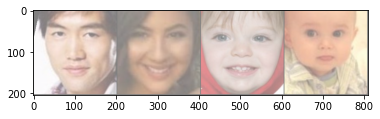

tensor([0, 1, 0, 0])
tensor([[ 0.1179, -0.2937],
        [-1.7512,  1.5783],
        [-0.1330, -0.0258],
        [ 0.5288, -0.7247]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0, 1, 1, 0], device='cuda:0')
Predicted:   Male Female Female  Male


In [10]:
dataiter = iter(testloader)
pog, something, labels = dataiter.next()
# print images
imshow(torchvision.utils.make_grid(pog))

outputs = net(pog.cuda())
print(labels)

classes = ("Male", "Female")
_, predicted = torch.max(outputs, 1)

print(outputs)
print(predicted)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [11]:
# now im testing for accuracy
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, _, labels = data
        outputs = net(images.cuda())
        _, predicted = torch.max(outputs.cuda(), 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print(correct / total)

0.7402862985685071


In [12]:
PATH = './pth_files/gender.pth'
torch.save(net.state_dict(), PATH)